# Emotion classification project

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, floor

import librosa as lr
import librosa.feature as lrf
import librosa.display as lrd

import joblib
import os

from pprint import pprint

np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

In [14]:
from multiprocessing import Pool
from FeatureExtractor import feature_extractor
import glob

test_path='speech-emotion-recognition-ravdess-data/Actor_17/03-01-04-01-01-01-17.wav'

## About the RAVDESS dataset

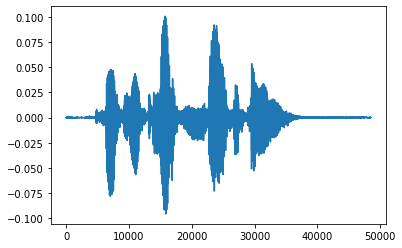

In [3]:
audio, _ = lr.load(test_path, mono=True, offset=0.8, duration=2.2)

plt.plot(audio)

## Feature extraction

In [ ]:
%%time

data = []
target_class_list= []
n_masks = 2


file_list = glob.glob('speech-emotion-recognition-ravdess-data/Actor_*/*')
arg_list = [(x, n_masks, True) for x in file_list]

with Pool(processes=4) as pool:
    processed_samples = pool.starmap(feature_extractor, arg_list)
    for s in processed_samples:
        data.extend(s)


for f_name in file_list:
    target_class = int(f_name.split('-')[6])
    target_class_list.extend([target_class]*(n_masks+1))

    
data = np.asarray(data)
target = np.asarray(target_class_list)-1

In [19]:
print(data.shape)
print(target.shape)

(4320, 20140)
(4320,)


In [3]:
# joblib.dump(data, 'data/data'), joblib.dump(target, 'data/target')

(['data/data'], ['data/target'])

## Model building

In [5]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import RFECV, RFE, SelectKBest, chi2

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC
from xgboost import XGBClassifier

from IncrementalSearch import incremental_search, time_taken
import scipy.stats as sst

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_validate, train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [6]:
%%time

data, target = joblib.load('data/data'), joblib.load('data/target')

target_labels = ['neutral', 
                 'calm', 
                 'happy', 
                 'sad', 
                 'angry', 
                 'fearful', 
                 'disgust', 
                 'surprised']

print(data.shape)
print(target.shape)

(4320, 20140)
(4320,)
Wall time: 235 ms


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(3456, 20140)
(864, 20140)
(3456,)
(864,)


### Inspecting feature importances

In [15]:
ss = StandardScaler().fit(X_train)
scaled_flat_sample = ss.transform(feature_extractor(test_path, 0, True)[0].reshape(1,-1))

sample = np.vstack([returns[0] for returns in feature_extractor(test_path, 0, False)])
shape = sample.shape

scaled_sample = scaled_flat_sample.reshape(shape)

print('\nSample shape:', shape)

processing with id: 1028 file: speech-emotion-recognition-ravdess-data/Actor_17/03-01-04-01-01-01-17.wav
processing with id: 1028 file: speech-emotion-recognition-ravdess-data/Actor_17/03-01-04-01-01-01-17.wav

Sample shape: (212, 95)


In [10]:
min_features = 2

feature_selector = RFECV(RandomForestClassifier(), min_features_to_select=min_features, step=0.1, cv=5, verbose=10, n_jobs=-1).fit(X_train, y_train)

joblib.dump(feature_selector, 'models/feature_selector')

Fitting estimator with 20140 features.
Fitting estimator with 18126 features.
Fitting estimator with 16112 features.
Fitting estimator with 14098 features.
Fitting estimator with 12084 features.
Fitting estimator with 10070 features.
Fitting estimator with 8056 features.
Fitting estimator with 6042 features.
Fitting estimator with 4028 features.


['models/feature_selector']

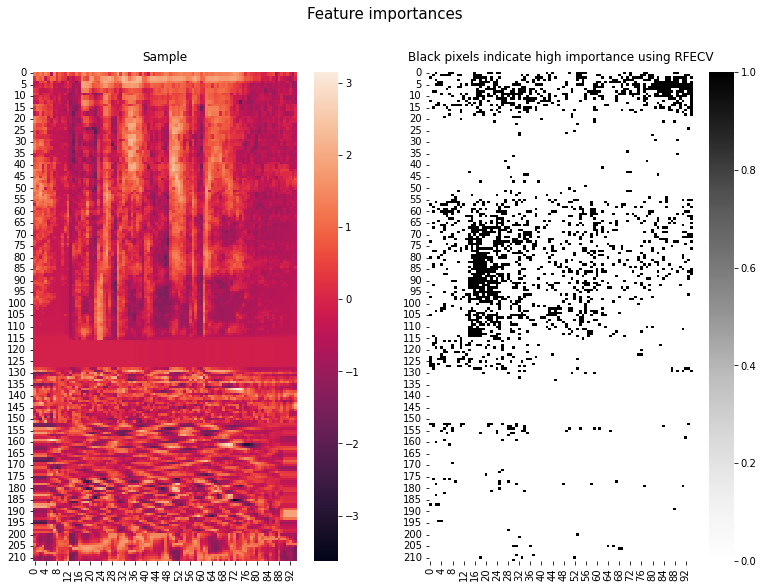

In [16]:
feature_selector = joblib.load('models/feature_selector')

grid = feature_selector.ranking_.reshape(shape)
ones = (grid == 1).astype(int)

fig , ax = plt.subplots(1,2, figsize=(13,9))

fig.suptitle('Feature importances', fontsize=(15))
sns.heatmap(scaled_sample, ax=ax[0])
sns.heatmap(ones, ax=ax[1], cmap='Greys')
ax[0].set_title('Sample', y=1.01)
ax[1].set_title('Black pixels indicate high importance using RFECV', y=1.01)
plt.show()

### Evaluating default performance

In [ ]:
%%time

default_pipes = [make_pipeline(RFE(RandomForestClassifier(), n_features_to_select=4000, step=0.1), StandardScaler(), LogisticRegression()),
                 make_pipeline(RFE(RandomForestClassifier(), n_features_to_select=4000, step=0.1), StandardScaler(), SVC()),
                 make_pipeline(RFE(RandomForestClassifier(), n_features_to_select=4000, step=0.1), StandardScaler(), SGDClassifier()),
                 make_pipeline(RFE(RandomForestClassifier(), n_features_to_select=4000, step=0.1), RandomForestClassifier()),
                 make_pipeline(RFE(RandomForestClassifier(), n_features_to_select=4000, step=0.1), XGBClassifier(tree_method='gpu_hist', objective='multi:softmax', eval_metric='mlogloss'))]

results = []

for pipe in default_pipes:
    print(f'Fitting estimator {pipe[-1]} with deafult parameters\n')
    
    result = cross_validate(pipe, X_train, y_train, scoring='f1_macro', n_jobs=-1, verbose=10, cv=5)
    results.append(result)
    

In [ ]:
default_results = joblib.load('models/default_results')

for name in default_results:
    score = np.mean(default_results[name]['test_score'])
    std = np.std(default_results[name]['test_score'])
    time = np.mean(default_results[name]['fit_time'])
    
    print('\n========== Evaluation ============\n')
    print(f'With estimator: {name}\n')
    print(f"Mean F1-score: {score}")
    print(f"Standard deviation: {std}\n")
    print(f"Average fit time: {time_taken(time, False)}")
    print('\n============== END ===============\n')


### Model evaluation and hyperparameter tuning

In [75]:
searches, results = joblib.load('searches/SVCSearch'), joblib.load('searches/LRResults')

In [ ]:
sorted_results = results[['mean_test_score', 'std_test_score', 'rank_test_score', 'n_samples', 'params']].sort_values(['n_samples'], ascending=False)

with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 100): display(sorted_results[:20])

In [73]:
def get_reference(results_frame):    
    
    samples = np.flip(results['n_samples'].unique())

    sorted_results = results[['mean_test_score','n_samples', 'params']].sort_values('mean_test_score', ascending=False)

    sorted_params_last = [str(p) for p in sorted_results[sorted_results['n_samples']==samples[0]]['params'].tolist()]

    reference = []

    for i, n_sample in enumerate(samples[1:]):
        sorted_params_previous_iteration = [str(p) for p in sorted_results[sorted_results['n_samples']==n_sample]['params'].tolist()]

        if i == 0:
            for j, p1 in enumerate(sorted_params_last):
                for k, p2 in enumerate(sorted_params_previous_iteration):
                    if p1 == p2:
                        reference.append([j+1, k+1])

        else:
            for j, p1 in enumerate(sorted_params_last):
                for k, p2 in enumerate(sorted_params_previous_iteration):
                    if p1 == p2:
                        reference[j].append(k+1)
    
    return reference

In [76]:
get_reference(results)

[[1, 18, 74, 327],
 [2, 9, 43, 453],
 [3, 2, 100, 527],
 [4, 15, 62, 79],
 [5, 6, 89, 408],
 [6, 20, 14, 22],
 [7, 13, 84, 284],
 [8, 4, 56, 303],
 [9, 7, 69, 38],
 [10, 17, 66, 388],
 [11, 1, 55, 397],
 [12, 5, 54, 452],
 [13, 19, 29, 170],
 [14, 3, 60, 349],
 [15, 8, 13, 23],
 [16, 14, 45, 256],
 [17, 10, 4, 117],
 [18, 12, 87, 124],
 [19, 11, 92, 436],
 [20, 16, 83, 34]]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
for mod in models:    
    print('\n', mod.__class__.__name__, '\n')
    y_pred = mod.predict(X_test_transformed)
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True).T)

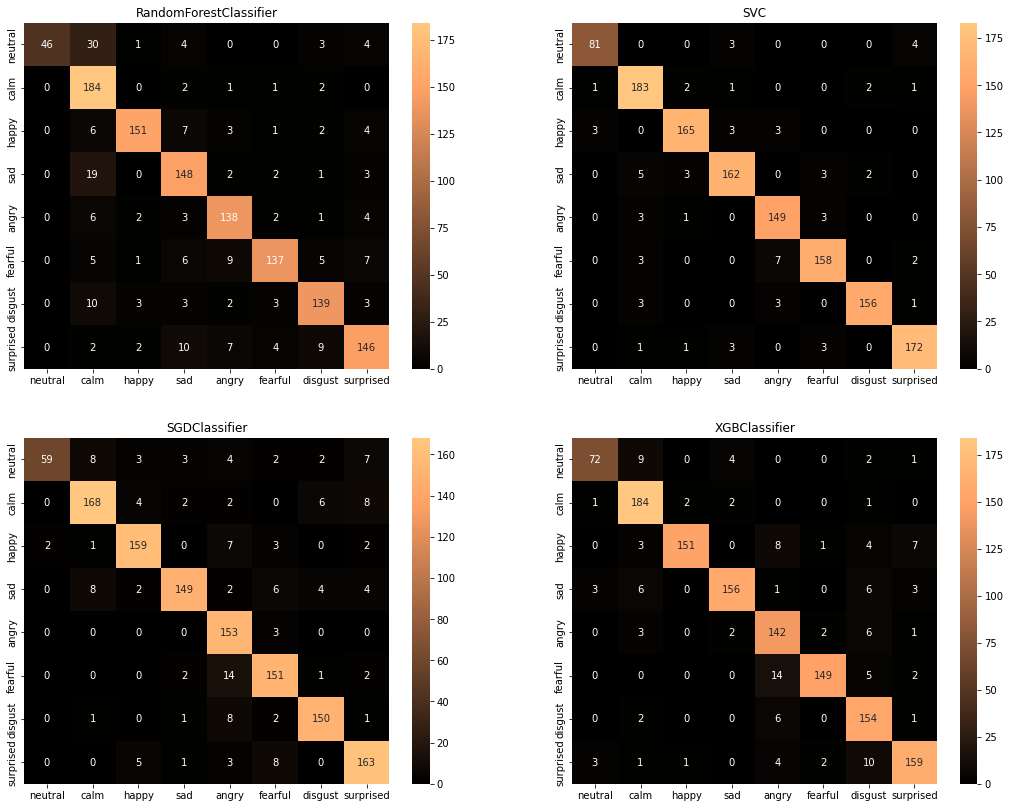

In [193]:
fig, axs = plt.subplots(2,2, figsize=(18,14))

axlist = axs.flatten()

for ax, mod in zip(axlist, models):
    y_pred = mod.predict(X_test_transformed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='copper', xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title(mod.__class__.__name__)

In [201]:
client.close()

### Convolution neural network

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [9]:
X_train, X_test, y_train, y_test = train_test_split(joblib.load('data/data'), joblib.load('data/target'), test_size=0.2)

target_labels = ['neutral', 
                 'calm', 
                 'happy', 
                 'sad', 
                 'angry', 
                 'fearful', 
                 'disgust', 
                 'surprised']

In [10]:
print(X_train.shape)
print(y_train.shape)

(3456, 20140)
(3456,)


In [11]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [12]:
X_train_scaled = X_train_scaled.reshape(3456, 212, 95, 1).astype(np.float32)
X_test_scaled = X_test_scaled.reshape(864, 212, 95, 1).astype(np.float32)

In [13]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(3456, 212, 95, 1)
(864, 212, 95, 1)


In [16]:
y_train = keras.utils.to_categorical(y_train, 8)
y_test = keras.utils.to_categorical(y_test, 8)

print(y_train.shape)
print(y_test.shape)

(3456, 8)
(864, 8)


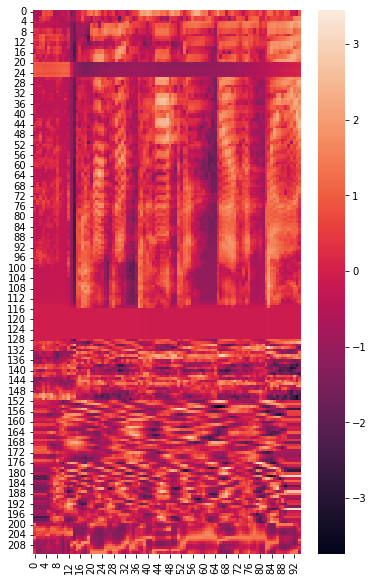

In [17]:
plt.figure(figsize=(6,10))
sns.heatmap(X_train_scaled[0][:,:,0])
plt.show()

In [14]:
network_model = Sequential()

network_model.add(Input(shape=X_train_scaled[1].shape))

network_model.add(Conv2D(32, 3, activation='relu'))
network_model.add(Conv2D(32, 3, activation='relu'))
network_model.add(MaxPooling2D(pool_size=(3,3)))

network_model.add(Conv2D(32, 3, activation='relu'))
network_model.add(Conv2D(32, 3, activation='relu'))
network_model.add(MaxPooling2D(pool_size=(3,3)))

network_model.add(Dropout(0.50))

network_model.add(Flatten())
network_model.add(Dense(512, activation='relu'))

network_model.add(Dropout(0.50))

network_model.add(Dense(256, activation='relu'))

network_model.add(Dense(8, activation='softmax'))

network_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 210, 93, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 208, 91, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 69, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 67, 28, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 65, 26, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 8, 32)        0         
 2D)                                                    

In [15]:
opt = keras.optimizers.Adam()

network_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = network_model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test), shuffle=True)

Epoch 1/50
108/108 [==============================] - 10s 56ms/step - loss: 1.7803 - accuracy: 0.3053 - val_loss: 1.5150 - val_accuracy: 0.4537
Epoch 2/50
108/108 [==============================] - 6s 54ms/step - loss: 1.4624 - accuracy: 0.4416 - val_loss: 1.2757 - val_accuracy: 0.5278
Epoch 3/50
108/108 [==============================] - 6s 54ms/step - loss: 1.1857 - accuracy: 0.5645 - val_loss: 1.0495 - val_accuracy: 0.6123
Epoch 4/50
108/108 [==============================] - 6s 54ms/step - loss: 0.9630 - accuracy: 0.6548 - val_loss: 0.8132 - val_accuracy: 0.7049
Epoch 5/50
108/108 [==============================] - 6s 54ms/step - loss: 0.7448 - accuracy: 0.7263 - val_loss: 0.5971 - val_accuracy: 0.7847
Epoch 6/50
108/108 [==============================] - 6s 54ms/step - loss: 0.6055 - accuracy: 0.7839 - val_loss: 0.5767 - val_accuracy: 0.7731
Epoch 7/50
108/108 [==============================] - 6s 54ms/step - loss: 0.4782 - accuracy: 0.8304 - val_loss: 0.3593 - val_accuracy: 0.868

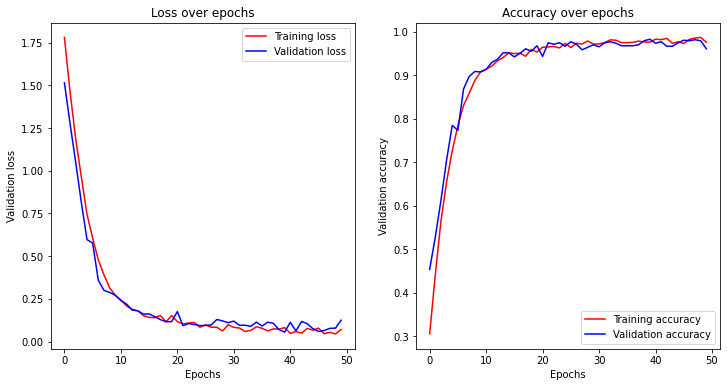

In [16]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,2,1)
ax.plot(range(50), history.history['loss'], 'r', label='Training loss')
ax.plot(range(50), history.history['val_loss'], 'b', label='Validation loss')
ax.legend()
ax.set_xlabel('Epochs'), ax.set_ylabel('Validation loss')
ax.set_title('Loss over epochs')

ax = fig.add_subplot(1,2,2)
ax.plot(range(50), history.history['accuracy'], 'r', label='Training accuracy')
ax.plot(range(50), history.history['val_accuracy'], 'b', label='Validation accuracy')
ax.legend()
ax.set_xlabel('Epochs'), ax.set_ylabel('Validation accuracy')
ax.set_title('Accuracy over epochs')

plt.show()

In [19]:
network_model2 = Sequential()

network_model2.add(Input(shape=X_train_scaled[1].shape))

network_model2.add(Conv2D(32, 3, activation='relu'))
network_model2.add(Conv2D(32, 3, activation='relu'))
network_model2.add(MaxPooling2D(pool_size=(3,3)))

network_model2.add(Conv2D(32, 3, activation='relu'))
network_model2.add(Conv2D(32, 3, activation='relu'))
network_model2.add(MaxPooling2D(pool_size=(3,3)))


network_model2.add(Flatten())
network_model2.add(Dense(1024, activation='relu'))


network_model2.add(Dense(8, activation='softmax'))

network_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 210, 93, 32)       320       
                                                                 
 conv2d_9 (Conv2D)           (None, 208, 91, 32)       9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 69, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 67, 28, 32)        9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 65, 26, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 21, 8, 32)        0         
 2D)                                                  

In [26]:
network_model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = network_model2.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test), shuffle=True)

Epoch 1/50
108/108 [==============================] - 6s 55ms/step - loss: 2.1159 - accuracy: 0.1481 - val_loss: 2.0518 - val_accuracy: 0.1505
Epoch 2/50
108/108 [==============================] - 6s 53ms/step - loss: 1.7691 - accuracy: 0.3139 - val_loss: 1.5698 - val_accuracy: 0.3981
Epoch 3/50
108/108 [==============================] - 6s 53ms/step - loss: 1.3968 - accuracy: 0.4797 - val_loss: 1.3149 - val_accuracy: 0.4977
Epoch 4/50
108/108 [==============================] - 6s 53ms/step - loss: 1.1284 - accuracy: 0.5807 - val_loss: 1.2150 - val_accuracy: 0.5405
Epoch 5/50
108/108 [==============================] - 6s 53ms/step - loss: 0.8976 - accuracy: 0.6609 - val_loss: 1.0028 - val_accuracy: 0.6470
Epoch 6/50
108/108 [==============================] - 6s 53ms/step - loss: 0.6745 - accuracy: 0.7622 - val_loss: 0.9210 - val_accuracy: 0.6840
Epoch 7/50
108/108 [==============================] - 6s 53ms/step - loss: 0.4818 - accuracy: 0.8281 - val_loss: 0.8570 - val_accuracy: 0.7338

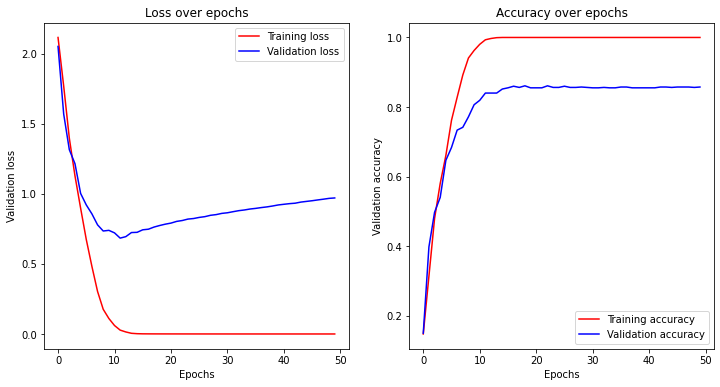

In [27]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,2,1)
ax.plot(range(50), history.history['loss'], 'r', label='Training loss')
ax.plot(range(50), history.history['val_loss'], 'b', label='Validation loss')
ax.legend()
ax.set_xlabel('Epochs'), ax.set_ylabel('Validation loss')
ax.set_title('Loss over epochs')

ax = fig.add_subplot(1,2,2)
ax.plot(range(50), history.history['accuracy'], 'r', label='Training accuracy')
ax.plot(range(50), history.history['val_accuracy'], 'b', label='Validation accuracy')
ax.legend()
ax.set_xlabel('Epochs'), ax.set_ylabel('Validation accuracy')
ax.set_title('Accuracy over epochs')

plt.show()

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [18]:
y_pred = np.argmax(network_model.predict(X_test_scaled), axis=-1)
y_test = np.argmax(y_test, axis=-1)

In [19]:
print(y_pred.shape)
print(y_test.shape)

(864,)
(864,)


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        47
           1       0.99      0.98      0.99       112
           2       0.96      0.92      0.94       122
           3       0.99      0.96      0.98       128
           4       0.99      0.91      0.95       114
           5       0.95      0.97      0.96       126
           6       0.96      0.99      0.97       111
           7       0.90      0.99      0.94       104

    accuracy                           0.96       864
   macro avg       0.96      0.96      0.96       864
weighted avg       0.96      0.96      0.96       864



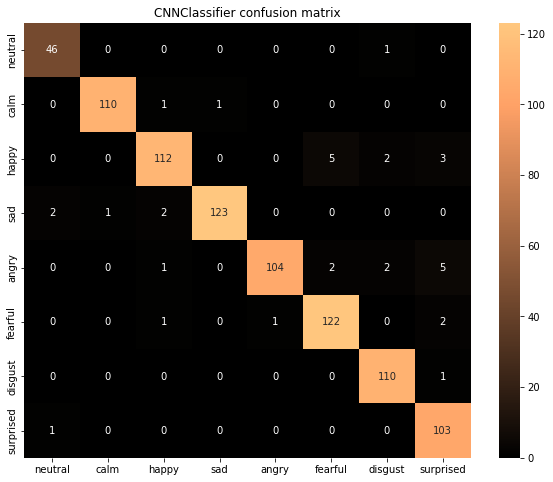

In [21]:
fig = plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='copper', xticklabels=target_labels, yticklabels=target_labels)
plt.title('CNNClassifier confusion matrix')
plt.show()

In [54]:
network_model.save('models/CNNClassifier.hdf5')